In [16]:
import numpy as np
import pandas as pd
import bilby
import matplotlib.pylab as plt
import glob

In [17]:
# compute log joint-pe BLU for an injection pair from runs
def get_blu(index):
    t1,t2 = trigger_pairs[index,:2].astype('int')
    bext = trigger_pairs[index,2]
    pair_dir=str(t1)+'_'+str(t2)
    shell_comm= '%s/%s'%(bilby_dirs,pair_dir)
    result_files = glob.glob(shell_comm+'/outdir_*/result/*.json')
    log_joint_BLU = 0
    print(index)
    if len(result_files) == 3:
        t1_out=glob.glob(shell_comm + '/outdir_'+str(t1) + '/result/*.json')[0]
        t2_out=glob.glob(shell_comm + '/outdir_'+str(t2) + '/result/*.json')[0]
        joint_out=glob.glob(shell_comm + '/outdir_'+pair_dir + '/result/*.json')[0]
        t1_res=bilby.result.read_in_result(t1_out)
        t2_res=bilby.result.read_in_result(t2_out)
        joint_res=bilby.result.read_in_result(joint_out)
        log_joint_BLU = joint_res.log_evidence-(t1_res.log_evidence + t2_res.log_evidence)
    else:
        print('result not available')

    return [bext,log_joint_BLU]

In [18]:
event = 'GW190915' # GW190915 or GW190727

In [19]:
if event == 'GW190727':
    inj_file = '../haris_GW190727/GW190727_LHV_LHV_Bext_above_minus5.dat'
    trigger_pairs=np.genfromtxt(inj_file,skip_header=True)
    n=len(trigger_pairs[:,0])
    out = 'cardiff_010121_GW19O727'
    bilby_dirs='../run_dir/' + out
if event == 'GW190915':
    inj_file = '../haris_GW190915/GW190915_LHV_LHV_Bext_above_minus5.dat'
    trigger_pairs=np.genfromtxt(inj_file,skip_header=True)
    n=len(trigger_pairs[:,0])
    out = 'cardif_GW19O915_190121_prior'
    bilby_dirs='../run_dir/' + out

# Save BLUs for each injection pair (skip if already saved)

In [22]:
#blus=np.array([get_blu(i) for i in range(n)])

In [23]:
#np.savez('../results/'+out,blus=blus)

# Load saved BLUs

In [26]:
blus=dict(np.load('../results/'+out+'.npz'))['blus']
missing_ids=np.where(blus[:,1] == 0)[0]
print(missing_ids.shape)

(3,)


In [27]:
# load blus for the missing ids if available
blus[missing_ids,:]=np.array([get_blu(i) for i in missing_ids])
np.savez('../results/'+out,blus=blus)

12
result not available
28
result not available
124
result not available


In [28]:
blus.shape

(162, 2)

In [29]:
finished_ids=np.where(blus[:,1] != 0)[0]


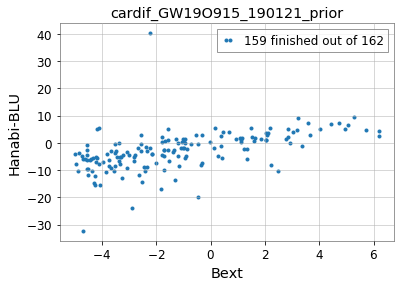

finished injs:  159 , total injs:  162


In [30]:
plt.plot(blus[finished_ids,0],blus[finished_ids,1],'.',label=str(len(finished_ids)) + ' finished out of '+ str(n))
plt.xlabel('Bext')
plt.ylabel('Hanabi-BLU')
plt.title(out)
plt.legend()
plt.savefig('../results/'+out+'-corr')

#plt.grid()
plt.show()
print('finished injs: ' ,len(finished_ids),', total injs: ' ,n)

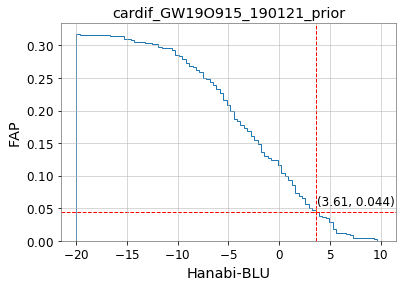

In [31]:
correction_factor = n/len(finished_ids)
blu_hanabi = blus[finished_ids,1]
bins=np.linspace(-20,10,30*3)
blu_event =3.61
x=plt.hist(blu_hanabi,bins=bins,histtype='step',cumulative=-1,weights=np.ones_like(blu_hanabi)*correction_factor/500)
idx=(x[1]>blu_event - 0.025) & (x[1]<blu_event + 0.025)
far_event=x[0][idx[:-1]][0]
plt.xlabel('Hanabi-BLU')
plt.plot(blu_event,far_event,'+')
plt.axhline(far_event,ls='dashed',color='r',lw=1)
plt.axvline(blu_event,ls='dashed',color='r',lw=1)
plt.annotate('('+ str(blu_event)+ ', '+ str(far_event)[:5] + ')' ,xy=(blu_event+0.1,far_event+0.01),fontsize=12,color='black')
plt.ylabel('FAP')
plt.title(out)
plt.savefig('../results/'+out+'-FAP')
plt.show()